In [107]:
import pandas as pd
import numpy as np

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [109]:
ny_map = pd.read_json("ny_map_data_res80.json")

In [110]:
len(ny_map)

6400

In [111]:
ny_map.head()

,county_name,lat,lng,state
0,Pike,41.403671,-74.984937,PA
1,Kawartha Lakes,44.788228,-79.055823,ON
2,Montgomery,42.920886,-74.476076,NY
3,Chautauqua,42.162278,-79.666456,NY
4,Rensselaer,42.862532,-73.661899,NY


In [112]:
ny_map["lng_rank"] = ny_map.lng.rank(method = "dense")
ny_map["lat_rank"] = ny_map.lat.rank(method = "dense")

In [113]:
ny_map["nyc"] = ny_map.county_name.map(lambda x: x in ["New York", "Bronx", "Richmond", "Kings", "Queens"])

In [114]:
ny_map_restricted = ny_map[ny_map.state == "NY"]

In [115]:
ny_map_restricted.groupby("county_name").count().sort_values("lat").head()

,lat,lng,state,lng_rank,lat_rank,nyc
county_name,,,,,,
New York,1,1,1,1,1,1
Bronx,2,2,2,2,2,2
Richmond,3,3,3,3,3,3
Kings,4,4,4,4,4,4
Queens,5,5,5,5,5,5


In [116]:
ny_map[ny_map.county_name == "Kings"]

,county_name,lat,lng,state,lng_rank,lat_rank,nyc
2491,Kings,40.645063,-73.967215,NY,59.0,4.0,True
2959,Kings,40.645063,-73.865443,NY,60.0,4.0,True
5992,Kings,40.703418,-73.967215,NY,59.0,5.0,True
6332,Kings,40.586709,-73.967215,NY,59.0,3.0,True


In [117]:
ny_map[ny_map.county_name == "Queens"]

,county_name,lat,lng,state,lng_rank,lat_rank,nyc
157,Queens,40.703418,-73.865443,NY,60.0,5.0,True
1205,Queens,40.761772,-73.865443,NY,60.0,6.0,True
3393,Queens,40.645063,-73.763671,NY,61.0,4.0,True
3554,Queens,40.703418,-73.763671,NY,61.0,5.0,True
4335,Queens,40.761772,-73.763671,NY,61.0,6.0,True


In [118]:
sns.set_style("dark")

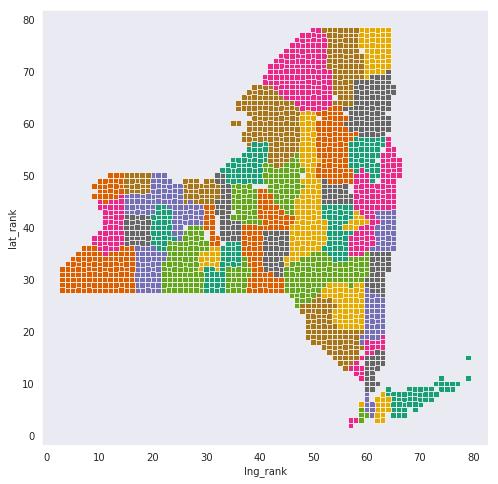

In [119]:
fig, ax = plt.subplots(figsize = (8, 8))

ax = sns.scatterplot(data = ny_map_restricted, x = "lng_rank", y = "lat_rank", hue = "county_name", marker = "s", palette = "Dark2", s = 35)

ax.legend_.remove()

In [120]:
ag_df = pd.read_csv("./election_results.csv")

In [121]:
county_totals = ag_df[~(ag_df.county == "All")].groupby(["county"], as_index = False)["ttl"].sum()

In [122]:
county_totals["county"] = county_totals.county.astype("str").map(lambda x: x.replace(".", " "))

In [123]:
get_bounds = lambda x: (
    ny_map_restricted
        .groupby(["county_name"], as_index = False)
        .agg({i: x for i in ["lng_rank", "lat_rank"]})
        .rename(columns = {i: "{}_{}".format(x, i) for i in ["lng_rank", "lat_rank"]})
)

In [124]:
num_squares = ny_map_restricted.groupby(["county_name"], as_index = False)["lng"].count().rename(columns = {"lng": "num_squares"})

In [125]:
county_shapes = (get_bounds("min")
    .merge(right = get_bounds("max"), on = ["county_name"], how = "left")
    .merge(right = num_squares, on = ["county_name"], how = "left")
    .merge(right = county_totals, left_on = ["county_name"], right_on = ["county"], how = "left"))

In [126]:
county_shapes["pre_mult"] = county_shapes.apply(lambda x: x.ttl / x.num_squares, axis = 1)
county_shapes["mult"] = county_shapes["pre_mult"] / county_shapes.pre_mult.min()
county_shapes["sqrt_mult"] = county_shapes.mult.map(lambda x: np.sqrt(x))

In [127]:
county_shapes.sort_values("mult", ascending = False).head()

,county_name,min_lng_rank,min_lat_rank,max_lng_rank,max_lat_rank,num_squares,county,ttl,pre_mult,mult,sqrt_mult
30,New York,59.0,6.0,59.0,6.0,1,New York,236022,236022.00,88891.402597,298.146613
23,Kings,59.0,3.0,60.0,5.0,4,Kings,296159,74039.75,27885.100649,166.988325
2,Bronx,60.0,7.0,60.0,8.0,2,Bronx,125978,62989.00,23723.129870,154.023147
40,Queens,60.0,4.0,61.0,6.0,5,Queens,182995,36599.00,13784.038961,117.405447
42,Richmond,57.0,2.0,58.0,3.0,3,Richmond,25851,8617.00,3245.363636,56.968093


In [128]:
for i in ["lng", "lat"]:
    county_shapes["mid_{}_rank".format(i)] = (county_shapes["min_{}_rank".format(i)] +
        ((county_shapes["max_{}_rank".format(i)] - county_shapes["min_{}_rank".format(i)]) / 2))

In [133]:
ny_map_county_shapes = ny_map_restricted.merge(right = county_shapes, on = ["county_name"], how= "left")

In [134]:
ny_map_county_shapes[ny_map_county_shapes.nyc].head()

,county_name,lat,lng,state,lng_rank,lat_rank,nyc,min_lng_rank,min_lat_rank,max_lng_rank,max_lat_rank,num_squares,county,ttl,pre_mult,mult,sqrt_mult,mid_lng_rank,mid_lat_rank
52,Queens,40.703418,-73.865443,NY,60.0,5.0,True,60.0,4.0,61.0,6.0,5,Queens,182995,36599.00,13784.038961,117.405447,60.5,5.0
431,Queens,40.761772,-73.865443,NY,60.0,6.0,True,60.0,4.0,61.0,6.0,5,Queens,182995,36599.00,13784.038961,117.405447,60.5,5.0
444,Bronx,40.878481,-73.865443,NY,60.0,8.0,True,60.0,7.0,60.0,8.0,2,Bronx,125978,62989.00,23723.129870,154.023147,60.0,7.5
846,Richmond,40.586709,-74.068987,NY,58.0,3.0,True,57.0,2.0,58.0,3.0,3,Richmond,25851,8617.00,3245.363636,56.968093,57.5,2.5
911,Kings,40.645063,-73.967215,NY,59.0,4.0,True,59.0,3.0,60.0,5.0,4,Kings,296159,74039.75,27885.100649,166.988325,59.5,4.0


In [135]:
for i in ["lng", "lat"]:
    ny_map_county_shapes["scaled_{}_rank".format(i)] = ny_map_county_shapes.apply(
        lambda x: x["{}_rank".format(i)] + x["sqrt_mult"] * (x["{}_rank".format(i)] - x["mid_{}_rank".format(i)]),
        axis = 1)

In [136]:
ny_map_county_shapes[ny_map_county_shapes.nyc].head()

,county_name,lat,lng,state,lng_rank,lat_rank,nyc,min_lng_rank,min_lat_rank,max_lng_rank,...,num_squares,county,ttl,pre_mult,mult,sqrt_mult,mid_lng_rank,mid_lat_rank,scaled_lng_rank,scaled_lat_rank
52,Queens,40.703418,-73.865443,NY,60.0,5.0,True,60.0,4.0,61.0,...,5,Queens,182995,36599.00,13784.038961,117.405447,60.5,5.0,1.297277,5.000000
431,Queens,40.761772,-73.865443,NY,60.0,6.0,True,60.0,4.0,61.0,...,5,Queens,182995,36599.00,13784.038961,117.405447,60.5,5.0,1.297277,123.405447
444,Bronx,40.878481,-73.865443,NY,60.0,8.0,True,60.0,7.0,60.0,...,2,Bronx,125978,62989.00,23723.129870,154.023147,60.0,7.5,60.000000,85.011574
846,Richmond,40.586709,-74.068987,NY,58.0,3.0,True,57.0,2.0,58.0,...,3,Richmond,25851,8617.00,3245.363636,56.968093,57.5,2.5,86.484047,31.484047
911,Kings,40.645063,-73.967215,NY,59.0,4.0,True,59.0,3.0,60.0,...,4,Kings,296159,74039.75,27885.100649,166.988325,59.5,4.0,-24.494162,4.000000


In [138]:
nyc_map_county_shapes = ny_map_county_shapes[ny_map_county_shapes.nyc]

In [139]:
nyc_map_county_shapes.head()

,county_name,lat,lng,state,lng_rank,lat_rank,nyc,min_lng_rank,min_lat_rank,max_lng_rank,...,county,ttl,pre_mult,mult,sqrt_mult,mid_lng_rank,mid_lat_rank,scaled_lng_rank,scaled_lat_rank,sqrt_mult_int
52,Queens,40.703418,-73.865443,NY,60.0,5.0,True,60.0,4.0,61.0,...,Queens,182995,36599.00,13784.038961,117.405447,60.5,5.0,1.297277,5.000000,117
431,Queens,40.761772,-73.865443,NY,60.0,6.0,True,60.0,4.0,61.0,...,Queens,182995,36599.00,13784.038961,117.405447,60.5,5.0,1.297277,123.405447,117
444,Bronx,40.878481,-73.865443,NY,60.0,8.0,True,60.0,7.0,60.0,...,Bronx,125978,62989.00,23723.129870,154.023147,60.0,7.5,60.000000,85.011574,154
846,Richmond,40.586709,-74.068987,NY,58.0,3.0,True,57.0,2.0,58.0,...,Richmond,25851,8617.00,3245.363636,56.968093,57.5,2.5,86.484047,31.484047,56
911,Kings,40.645063,-73.967215,NY,59.0,4.0,True,59.0,3.0,60.0,...,Kings,296159,74039.75,27885.100649,166.988325,59.5,4.0,-24.494162,4.000000,166


In [140]:
import colorlover as cl

In [141]:
colors = [[i / 255 for i in j] for j in cl.to_numeric(cl.scales['5']['qual']['Dark2'])]

In [163]:
def ny_scatter(df):
    fig, ax = plt.subplots(figsize = (8, 8))
    for ind, county in enumerate(df.county_name.unique()):
        county_df = df[df.county_name == county]
        ax.scatter(
            y = county_df.scaled_lat_rank,
            x = county_df.scaled_lng_rank,
            s = county_df.sqrt_mult,
            marker = "s",
            label = county,
            alpha = 0.7,
            color = colors[ind % 5],
            edgecolor = "none")
    # ax.legend(loc = 9, bbox_to_anchor = (0.5,0))
    return fig

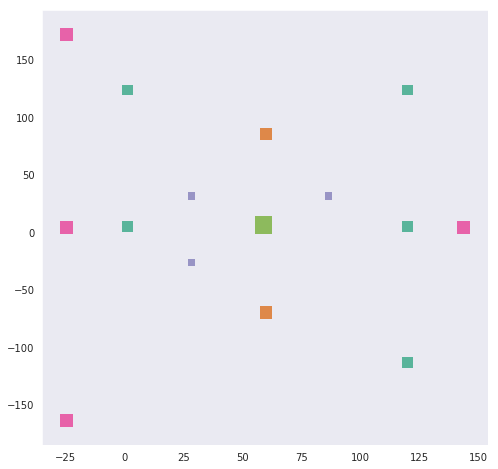

In [164]:
fig = ny_scatter(ny_map_county_shapes[ny_map_county_shapes.nyc])

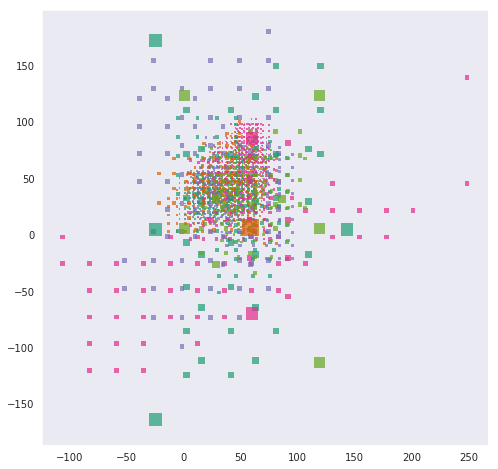

In [165]:
fig = ny_scatter(ny_map_county_shapes)

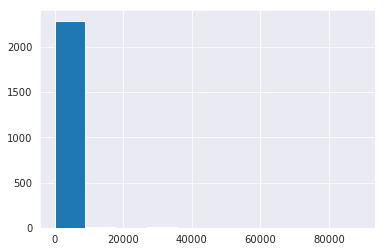

In [155]:
ny_map_county_shapes.mult.hist()

In [159]:
for i in ["lat", "lng"]:
    county_shapes["{}_rank_range".format(i)] = county_shapes["max_{}_rank".format(i)] - county_shapes["min_{}_rank".format(i)] + 1
    for sj, j in enumerate(["min", "max"]):
        county_shapes["scaled_{}_{}_rank".format(j, i)] = county_shapes.apply(
            lambda x: x["mid_{}_rank".format(i)] + ((2 * sj - 1) * x["sqrt_mult"] * x["{}_rank_range".format(i)] / 2),
            axis = 1)

In [162]:
county_shapes.to_csv("./ny_county_shapes.csv", index = False)